In [2]:
#use logits and dataloader to evaluate our models

#we can also load via the logits

import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 

# sys.path.append(os.environ.get("SAFARI_PATH", "."))

from src.models.sequence.long_conv_lm import ConvLMHeadModel

# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer

try:
    from tokenizers import Tokenizer  
except:
    pass

# https://github.com/openai/gpt-2/issues/131#issuecomment-492786058
# def preprocess(text):
#     text = text.replace("“", '"')
#     text = text.replace("”", '"')
#     return '\n'+text.strip()


class HG38Encoder:
    "Encoder inference for HG38 sequences"
    def __init__(self, model_cfg, ckpt_path, max_seq_len):
        self.max_seq_len = max_seq_len
        self.model, self.tokenizer = self.load_model(model_cfg, ckpt_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)

    def encode(self, seqs):
            
        results = []

        # sample code to loop thru each sample and tokenize first (char level)
        for seq in tqdm(seqs):
            
            if isinstance(self.tokenizer, Tokenizer):
                tokenized_seq = self.tokenizer.encode(seq).ids
            else:
                tokenized_seq = self.tokenizer.encode(seq)
            
            # can accept a batch, shape [B, seq_len, hidden_dim]
            logits, __ = self.model(torch.tensor([tokenized_seq]).to(device=self.device))

            # Using head, so just have logits
            results.append(logits)

        return results
        
            
    def load_model(self, model_cfg, ckpt_path):
        config = yaml.load(open(model_cfg, 'r'), Loader=yaml.FullLoader)
        model = ConvLMHeadModel(**config['model_config'])
        
        state_dict = torch.load(ckpt_path, map_location='cpu')

        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )

        model_state_dict = state_dict["state_dict"]

        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)

        model.load_state_dict(state_dict["state_dict"])

        # setup tokenizer
        if config['tokenizer_name'] == 'char':
            print("**Using Char-level tokenizer**")

            # add to vocab
            tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=self.max_seq_len + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
            )
            # print(tokenizer._vocab_str_to_int)
        else:
            raise NotImplementedError("You need to provide a custom tokenizer!")

        return model, tokenizer
        
        
# if __name__ == "__main__":

# SAFARI_PATH = os.getenv('SAFARI_PATH', '.')

# parser = argparse.ArgumentParser()

# parser.add_argument(
#     "--model_cfg",
#     default=f"{SAFARI_PATH}/configs/evals/hyena_small_150b.yaml",
# )

# parser.add_argument(
#     "--ckpt_path",
#     default=f"",
#     help="Path to model state dict checkpoint"
# )
    
# args = parser.parse_args()
    
# task = HG38Encoder(args.model_cfg, args.ckpt_path, max_seq_len=1024)

trained = HG38Encoder('/data/leslie/sarthak/hyena/hyena-dna/configs/evals/cCRE.yaml', '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-01-26/15-03-07-318248/checkpoints/last.ckpt', max_seq_len=1024)
original = HG38Encoder('/data/leslie/sarthak/hyena/hyena-dna/configs/evals/cCRE.yaml', '/data/leslie/sarthak/hyena/hyena-dna/hyenadna-tiny-1k-seqlen/weights.ckpt', max_seq_len=1024)
# # sample sequence, can pass a list of seqs (themselves a list of chars)
seqs = ["ACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGT"]
print(len(seqs[0]))
logits = trained.encode(seqs)
# print(logits)
print(logits[0].logits.shape)
logits2 = original.encode(seqs)
print(logits2[0].logits.shape)
# # breakpoint()

# predict 73 when th elength is 72 because they also predict that last one that could be eos token
# predict through the input but remember we have an output for every single input

**Using Char-level tokenizer**
**Using Char-level tokenizer**
72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 195.14it/s]


torch.Size([1, 73, 16])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 218.41it/s]

torch.Size([1, 73, 16])


In [9]:
#need to modify this class to also get the y prediction sequence and make sure it makes sense

#use logits and dataloader to evaluate our models

#we can also load via the logits

import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 

# sys.path.append(os.environ.get("SAFARI_PATH", "."))

from src.models.sequence.long_conv_lm import ConvLMHeadModel

# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer

try:
    from tokenizers import Tokenizer  
except:
    pass

# https://github.com/openai/gpt-2/issues/131#issuecomment-492786058
# def preprocess(text):
#     text = text.replace("“", '"')
#     text = text.replace("”", '"')
#     return '\n'+text.strip()


class HG38Encoder:
    "Encoder inference for HG38 sequences"
    def __init__(self, model_cfg, ckpt_path, max_seq_len):
        self.max_seq_len = max_seq_len
        self.model, self.tokenizer = self.load_model(model_cfg, ckpt_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)

    def encode(self, seqs):
            
        results = []
        # outputs = []

        # sample code to loop thru each sample and tokenize first (char level)
        for seq in tqdm(seqs):
            
            if isinstance(self.tokenizer, Tokenizer):
                tokenized_seq = self.tokenizer.encode(seq).ids
            else:
                tokenized_seq = self.tokenizer.encode(seq)
            
            # can accept a batch, shape [B, seq_len, hidden_dim]
            logits, _ = self.model(torch.tensor([tokenized_seq]).to(device=self.device))

            # Using head, so just have logits
            results.append(logits)
            # outputs.append(output)

        return results
        
            
    def load_model(self, model_cfg, ckpt_path):
        config = yaml.load(open(model_cfg, 'r'), Loader=yaml.FullLoader)
        model = ConvLMHeadModel(**config['model_config'])
        
        state_dict = torch.load(ckpt_path, map_location='cuda:0')

        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )

        model_state_dict = state_dict["state_dict"]

        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)

        model.load_state_dict(state_dict["state_dict"])

        # setup tokenizer
        if config['tokenizer_name'] == 'char':
            print("**Using Char-level tokenizer**")

            # add to vocab
            tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=self.max_seq_len + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            # print(tokenizer._vocab_str_to_int)

        return model, tokenizer

trained = HG38Encoder('/data/leslie/sarthak/hyena/hyena-dna/configs/evals/cCRE.yaml', '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-01-26/15-03-07-318248/checkpoints/last.ckpt', max_seq_len=1024)
# original = HG38Encoder('/data/leslie/sarthak/hyena/hyena-dna/configs/evals/cCRE.yaml', '/data/leslie/sarthak/hyena/hyena-dna/hyenadna-tiny-1k-seqlen/weights.ckpt', max_seq_len=1024)
# # sample sequence, can pass a list of seqs (themselves a list of chars)
seqs = ["ACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGT"]
y_hat = trained.encode(seqs)
print(y_hat[0].logits.shape)
print(y[0])
print(trained.max_seq_len) #it is the 1024, but it's not padding here
# print(y_hat[0].logits[0,16,:])
# print(y[0][0,16,:])


**Using Char-level tokenizer**


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 216.85it/s]

torch.Size([1, 73, 16])
None
1024


In [15]:
print(isinstance(trained.tokenizer, Tokenizer)) #so doesn't do .ids, just tokenizes it

False


In [14]:
a = trained.tokenizer('A')['input_ids'] #completely identical tho
b = trained.tokenizer.encode('A')
print(a == b)
print(a)
print(b)
#just all 4 and then 7 and eos token of 1
#we need to do this padding, as this is what the model sees since it's always the same length


True
[7, 1]
[7, 1]


In [24]:
print(a:=trained.tokenizer('A', padding="max_length"))
#it's 1024 length
print(len(a['input_ids'])) #1024 + 2

{'input_ids': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

In [27]:
tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=trained.max_seq_len + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding = 'max_length',
                padding_side='left'
            )
print(a:=tokenizer('A', padding="max_length"))
print(len(a['input_ids'])) #1024 + 2
#see how many 4s there are in input ids
print(a['input_ids'].count(4)) #1024
#so makes it go to 1026, but we need to cut off so total length is 1023 actually

{'input_ids': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

In [29]:
print(trained.device) #eyo we got cuda

cuda


# with the padding, almost finished

In [28]:
#let's tokenize it with this option
class HG38Encoder:
    "Encoder inference for HG38 sequences"
    def __init__(self, model_cfg, ckpt_path, max_seq_len):
        self.max_seq_len = max_seq_len
        self.model, self.tokenizer = self.load_model(model_cfg, ckpt_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)

    def encode(self, seqs):
            
        results = []
        # outputs = []

        # sample code to loop thru each sample and tokenize first (char level)
        for seq in tqdm(seqs):
            
            if isinstance(self.tokenizer, Tokenizer):
                tokenized_seq = self.tokenizer.encode(seq, ).ids
            else:
                tokenized_seq = self.tokenizer(seq, padding="max_length")['input_ids']
            tokenized_seq = tokenized_seq[3:] #make it so the length is 1023 as that's what we expect
            # can accept a batch, shape [B, seq_len, hidden_dim]
            logits, _ = self.model(torch.tensor([tokenized_seq]).to(device=self.device))

            # Using head, so just have logits
            results.append(logits)
            # outputs.append(output)

        return results
        
            
    def load_model(self, model_cfg, ckpt_path):
        config = yaml.load(open(model_cfg, 'r'), Loader=yaml.FullLoader)
        model = ConvLMHeadModel(**config['model_config'])
        
        state_dict = torch.load(ckpt_path, map_location='cuda:0')

        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )

        model_state_dict = state_dict["state_dict"]

        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)

        model.load_state_dict(state_dict["state_dict"])

        # setup tokenizer
        if config['tokenizer_name'] == 'char':
            print("**Using Char-level tokenizer**")

            # add to vocab
            tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=self.max_seq_len + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            # print(tokenizer._vocab_str_to_int)

        return model, tokenizer

trained = HG38Encoder('/data/leslie/sarthak/hyena/hyena-dna/configs/evals/cCRE.yaml', '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-01-26/15-03-07-318248/checkpoints/last.ckpt', max_seq_len=1024)
# original = HG38Encoder('/data/leslie/sarthak/hyena/hyena-dna/configs/evals/cCRE.yaml', '/data/leslie/sarthak/hyena/hyena-dna/hyenadna-tiny-1k-seqlen/weights.ckpt', max_seq_len=1024)
# # sample sequence, can pass a list of seqs (themselves a list of chars)
seqs = ["ACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGTACGT"]
y_hat = trained.encode(seqs)
print(y_hat[0].logits.shape)
print(y[0]) #wait this is none, ignore this

**Using Char-level tokenizer**


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.26it/s]

torch.Size([1, 1023, 16])
None


# now test the data loader

In [37]:
from src.dataloaders.datasets.ccre_dataset import CcreDataset

import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 

# sys.path.append(os.environ.get("SAFARI_PATH", "."))

from src.models.sequence.long_conv_lm import ConvLMHeadModel

# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer

try:
    from tokenizers import Tokenizer  
except:
    pass

#make sure this is correct from the yaml files
tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
ccre = CcreDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True')
print(ccre[0][0].shape) #perfect, the length we expected, and it's already tokenized
print(ccre[0])
#add eos makes it so that it returns the right sequence length, adds the eos and bos and pads to make the right length, then remove box
#eos token only added to the end

torch.Size([1023])
(tensor([ 4,  4,  4,  ...,  8, 10,  9]), tensor([ 4,  4,  4,  ..., 10,  9,  1]))


In [41]:
#let's make sure that the number of 4s matches what we expect
print(ccre[0][0][0:25]) #1024
#yes exactly 23 4s, so we're good, that's the same as in the data
print(tokenizer.eos_token)
#now print the full vocab
print(tokenizer._vocab_str_to_int)
#so we can see that the sep is the eos token for some reason, and that everything looks as expected

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7,
        7])
[SEP]
{'[CLS]': 0, '[SEP]': 1, '[BOS]': 2, '[MASK]': 3, '[PAD]': 4, '[RESERVED]': 5, '[UNK]': 6, 'A': 7, 'C': 8, 'G': 9, 'T': 10, 'N': 11}


In [43]:
#now we actually load some data in batches
print(len(ccre))
#a decent number of items, but small enough that evaluation will be easy

105252


In [63]:
#now put thorugh model, get logits and calculate ce loss

class HG38Encoder:
    "Encoder inference for HG38 sequences"
    def __init__(self, model_cfg, ckpt_path, max_seq_len):
        self.max_seq_len = max_seq_len
        self.model, self.tokenizer = self.load_model(model_cfg, ckpt_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)

    def encode(self, seqs):
        # seqs = seqs.to(device=self.device)
        results = []
        # outputs = []

        # sample code to loop thru each sample and tokenize first (char level)
        
        # if isinstance(self.tokenizer, Tokenizer):
        #     tokenized_seq = self.tokenizer.encode(seq, ).ids
        # else:
        #     tokenized_seq = self.tokenizer(seq, padding="max_length")['input_ids']
        # tokenized_seq = tokenized_seq[3:] #make it so the length is 1023 as that's what we expect
        # can accept a batch, shape [B, seq_len, hidden_dim]
        logits = self.model(seqs)[0]

        # Using head, so just have logits
        results.append(logits)
        # outputs.append(output)

        return results
        
            
    def load_model(self, model_cfg, ckpt_path):
        config = yaml.load(open(model_cfg, 'r'), Loader=yaml.FullLoader)
        model = ConvLMHeadModel(**config['model_config'])
        
        state_dict = torch.load(ckpt_path, map_location='cuda:0')

        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )

        model_state_dict = state_dict["state_dict"]

        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)

        model.load_state_dict(state_dict["state_dict"])

        # setup tokenizer
        if config['tokenizer_name'] == 'char':
            print("**Using Char-level tokenizer**")

            # add to vocab
            tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=self.max_seq_len + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            # print(tokenizer._vocab_str_to_int)

        return model, tokenizer

trained = HG38Encoder('/data/leslie/sarthak/hyena/hyena-dna/configs/evals/cCRE.yaml', '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-01-26/15-03-07-318248/checkpoints/last.ckpt', max_seq_len=1024)

seq, target = ccre[0]
#now get the logits
# print(seq.shape)
#unsqueeze to make it a batch
seq = seq.unsqueeze(0)
seq = seq.to(device=trained.device)
print(seq.shape)
y_hat = trained.encode(seq)
print(y_hat[0].logits.shape)

**Using Char-level tokenizer**
torch.Size([1, 1023])
torch.Size([1, 1023, 16])


In [65]:
#compare the targets
print(target.shape)
print(target[16])
print(y_hat[0].logits[0,16,:])
#understands the pad

torch.Size([1023])
tensor(4)
tensor([ 0.8840, -0.4067,  0.7564,  0.7946,  9.7755,  0.8988,  0.8157,  0.2324,
        -0.2248, -0.4690, -0.5704,  0.4473,  0.7938,  0.8818,  0.8177,  0.8402],
       device='cuda:0', grad_fn=<SliceBackward0>)


In [68]:
#now test a different one
print(target[200])
print(y_hat[0].logits[0,200,:])
#yeah doing that well too
tokenizer.decode(9) #it's a G!

tensor(9)
tensor([-10.4342,  -5.4222, -10.2867, -10.5126, -10.5325, -10.2794, -10.3038,
          0.5174,   0.6755,   1.0137,   0.2429,  -9.4974, -10.2678, -10.0635,
        -10.2559, -10.3255], device='cuda:0', grad_fn=<SliceBackward0>)


'G'

In [74]:
#finally let's calculation ce loss
import torch.nn.functional as F
a=F.cross_entropy(y_hat[0].logits[0,:,:], target.to(trained.device), reduction='none')
print(a.shape)

torch.Size([1023])


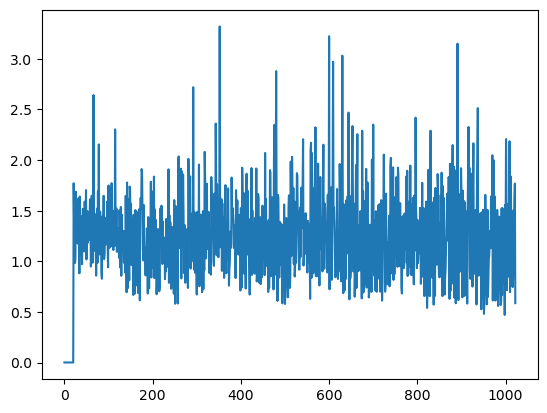

In [75]:
#now we plot a
import matplotlib.pyplot as plt
plt.plot(a.detach().cpu().numpy())

#0 loss on the pad, then its high on the rest of the sequence, which makes sense!

In [78]:
#now find 'accuracy' using the argmax
b = torch.argmax(y_hat[0].logits[0,:,:], dim=1).to('cpu')
#find the number that match target
print((b==target).sum())
#452 out of 1023, not bad

tensor(452)


# full loop calculating loss

In [1]:
#now put thorugh model, get logits and calculate ce loss

from src.dataloaders.datasets.ccre_dataset import CcreDataset

import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 

# sys.path.append(os.environ.get("SAFARI_PATH", "."))

from src.models.sequence.long_conv_lm import ConvLMHeadModel

# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import torch.nn.functional as F


try:
    from tokenizers import Tokenizer  
except:
    pass

#make sure this is correct from the yaml files
tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
ccre = CcreDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True')

class HG38Encoder:
    "Encoder inference for HG38 sequences"
    def __init__(self, model_cfg, ckpt_path, max_seq_len):
        self.max_seq_len = max_seq_len
        self.model, self.tokenizer = self.load_model(model_cfg, ckpt_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)

    def encode(self, seqs):
        # seqs = seqs.to(device=self.device)
        results = []
        # outputs = []

        # sample code to loop thru each sample and tokenize first (char level)
        
        # if isinstance(self.tokenizer, Tokenizer):
        #     tokenized_seq = self.tokenizer.encode(seq, ).ids
        # else:
        #     tokenized_seq = self.tokenizer(seq, padding="max_length")['input_ids']
        # tokenized_seq = tokenized_seq[3:] #make it so the length is 1023 as that's what we expect
        # can accept a batch, shape [B, seq_len, hidden_dim]
        logits = self.model(seqs)[0]

        # Using head, so just have logits
        results.append(logits)
        # outputs.append(output)

        return results
        
            
    def load_model(self, model_cfg, ckpt_path):
        config = yaml.load(open(model_cfg, 'r'), Loader=yaml.FullLoader)
        model = ConvLMHeadModel(**config['model_config'])
        
        state_dict = torch.load(ckpt_path, map_location='cuda:0')

        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )

        model_state_dict = state_dict["state_dict"]

        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)

        model.load_state_dict(state_dict["state_dict"])

        # setup tokenizer
        if config['tokenizer_name'] == 'char':
            print("**Using Char-level tokenizer**")

            # add to vocab
            tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=self.max_seq_len + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            # print(tokenizer._vocab_str_to_int)

        return model, tokenizer

trained = HG38Encoder('/data/leslie/sarthak/hyena/hyena-dna/configs/evals/cCRE.yaml', '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-01-26/15-03-07-318248/checkpoints/last.ckpt', max_seq_len=1024)
original = HG38Encoder('/data/leslie/sarthak/hyena/hyena-dna/configs/evals/cCRE.yaml', '/data/leslie/sarthak/hyena/hyena-dna/hyenadna-tiny-1k-seqlen/weights.ckpt', max_seq_len=1024)

**Using Char-level tokenizer**
**Using Char-level tokenizer**


In [2]:
full_loss = torch.zeros((len(ccre), 1023))
full_acc = torch.zeros((len(ccre), 1023))
for idx, (seq, target) in tqdm(enumerate(ccre), total=len(ccre)):
    target = target.to(trained.device)
    seq = seq.unsqueeze(0)
    seq = seq.to(device=trained.device)
    y_hat = trained.encode(seq)
    a=F.cross_entropy(y_hat[0].logits[0,:,:], target, reduction='none')
    full_loss[idx,:] = a.detach().cpu()
    b = torch.argmax(y_hat[0].logits[0,:,:], dim=1)
    full_acc[idx,:] = (b==target).detach().cpu()
    
#print the full mean of both loss and acc
print(full_loss.mean())
print(full_acc.mean())

#I reran it, but original values were 1.2147 and 0.4177 respectively for loss and acc
#actually is .4176 the second time, but I doubt it matters

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 105252/105252 [16:02<00:00, 109.31it/s]


tensor(1.2147)
tensor(0.4176)


In [3]:
#repeat for the original model

full_loss2 = torch.zeros((len(ccre), 1023))
full_acc2 = torch.zeros((len(ccre), 1023))
for idx, (seq, target) in tqdm(enumerate(ccre), total=len(ccre)):
    target = target.to(trained.device)
    seq = seq.unsqueeze(0)
    seq = seq.to(device=trained.device)
    y_hat = original.encode(seq)
    a=F.cross_entropy(y_hat[0].logits[0,:,:], target, reduction='none')
    full_loss2[idx,:] = a.detach().cpu()
    b = torch.argmax(y_hat[0].logits[0,:,:], dim=1)
    full_acc2[idx,:] = (b==target).detach().cpu()
    
#print the full mean of both loss and acc
print(full_loss2.mean())
print(full_acc2.mean())

#Again I reran it, but original values were 1.4388 and .3931 for the loss and accuracy respectively

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 105252/105252 [16:01<00:00, 109.48it/s]


tensor(1.4388)
tensor(0.3931)


In [89]:
#i didn't change what I was appending... so these values are for the original model
print(full_loss.mean())
print(full_acc.mean())

tensor(1.4388)
tensor(0.3931)


In [12]:
#let's test this batched approach
from torch.utils.data import DataLoader

# Assuming `ccre_dataset` is your dataset
ccre_loader = DataLoader(ccre, batch_size=32, shuffle=False) #results are identical even if you shuffle, obviously since it's just the mean
loader_loss = torch.zeros((len(ccre), 1023))
loader_acc = torch.zeros((len(ccre), 1023))
startidx = 0
for idx, (seq, target) in tqdm(enumerate(ccre_loader), total=len(ccre_loader)):
    b_size = seq.shape[0]
    target = target.to(trained.device)
    seq = seq.to(device=trained.device)
    y_hat = trained.encode(seq)
    # print(target.shape) #32, 1023
    # print(seq.shape) #32, 1023
    # print(len(y_hat)) #1
    # print(y_hat[0].logits.shape) #32, 1023, 16 as expected
    # break
    #now fix the accuracy and loss to work with batches
    logits_reshaped = y_hat[0].logits.view(-1, 16)
    target_reshaped = target.view(-1)
    
    losses = F.cross_entropy(logits_reshaped, target_reshaped, reduction='none')
    
    losses = losses.view(b_size, 1023)
    # print(losses.shape) #yeah as expected
    # break
    
    loader_loss[startidx:startidx+b_size,:] = losses.detach().cpu()
    
    # a=F.cross_entropy(y_hat[0].logits[0,:,:], target, reduction='none')
    # full_loss2[idx,:] = a.detach().cpu()
    
    b = torch.argmax(y_hat[0].logits, dim=2)
    loader_acc[startidx:startidx+b_size,:] = (b==target).detach().cpu()
    startidx += b_size
    # full_acc2[idx,:] = (b==target).detach().cpu()
print(loader_loss.mean())
print(loader_acc.mean())
#the real way to do it if we want to do it in batches
#can increase batch size, but had a 11GB gpu for now, if had A100, could do 512
#it does indeed work much faster, and the results are completely identical! So this is the new function we can use to evaluate our models!
#and again this is without RC

#also note this approach we use is near identical to what they do in terms of calculating loss and evlauating, so we just verified it 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3290/3290 [03:37<00:00, 15.14it/s]


tensor(1.2147)
tensor(0.4176)


In [16]:
#wait we had one with a lot more epochs, let's compare that too
trained_100 = HG38Encoder('/data/leslie/sarthak/hyena/hyena-dna/configs/evals/cCRE.yaml', '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-01-26/20-02-31-396880/checkpoints/last.ckpt', max_seq_len=1024)

e100loss = torch.zeros((len(ccre), 1023))
e100acc = torch.zeros((len(ccre), 1023))
startidx = 0
for idx, (seq, target) in tqdm(enumerate(ccre_loader), total=len(ccre_loader)):
    b_size = seq.shape[0]
    target = target.to(trained.device)
    seq = seq.to(device=trained.device)
    y_hat = trained_100.encode(seq)
    logits_reshaped = y_hat[0].logits.view(-1, 16)
    target_reshaped = target.view(-1)
    
    losses = F.cross_entropy(logits_reshaped, target_reshaped, reduction='none')
    
    losses = losses.view(b_size, 1023)
    
    e100loss[startidx:startidx+b_size,:] = losses.detach().cpu()
    
    b = torch.argmax(y_hat[0].logits, dim=2)
    e100acc[startidx:startidx+b_size,:] = (b==target).detach().cpu()
    startidx += b_size
    # full_acc2[idx,:] = (b==target).detach().cpu()
print(e100loss.mean())
print(e100acc.mean())

**Using Char-level tokenizer**


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3290/3290 [03:53<00:00, 14.11it/s]


tensor(1.1938)
tensor(0.4314)


In [17]:
#since it might be the pad let's calculate the mean from 24 onwards
print('original loss after 24:', float(full_loss2[:,24:].mean()))
print('trained loss after 24:', float(full_loss[:,24:].mean()))
print('trained 100 epochs loss after 24:', float(e100loss[:,24:].mean()))
print('original accuracy after 24:', float(full_acc2[:,24:].mean()))
print('trained accuracy after 24:', float(full_acc[:,24:].mean()))
print('trained 100 epochs accuracy after 24:', float(e100acc[:,24:].mean()))

#yeah... it might just straight up be the padding

original loss after 24: 1.2463696002960205
trained loss after 24: 1.2398368120193481
trained 100 epochs loss after 24: 1.2197294235229492
original accuracy after 24: 0.4019705355167389
trained accuracy after 24: 0.40536975860595703
trained 100 epochs accuracy after 24: 0.419145792722702


# evaluate it with the longer ones, see if the sequence matches what is expected
so we will load the tokenizer, make sure all 1023 are translated exactly as expected, then the full length should be 1024

In [1]:
from src.dataloaders.datasets.ccre_dataset import CcreDataset

import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 

# sys.path.append(os.environ.get("SAFARI_PATH", "."))

from src.models.sequence.long_conv_lm import ConvLMHeadModel

# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import torch.nn.functional as F


try:
    from tokenizers import Tokenizer  
except:
    pass

#make sure this is correct from the yaml files
tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
ccre = CcreDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True')

a,b = ccre[0]
print(a.shape, b.shape)

torch.Size([1023]) torch.Size([1023])


In [3]:
#the actual sequence should be
#CAGAAGTTGGGC
print(a)
print(b)

print(tokenizer.decode(a))
print(tokenizer.decode(b))

#it shouldu end with GACT but it seems the last token is cut off, eh who really cares, it's because we added bos token at first then we removed it
#which is fine, maybe it's there and it's 1025 actual length, or it's just 1023, doesn't really matter


tensor([8, 7, 9,  ..., 9, 7, 8])
tensor([7, 9, 7,  ..., 7, 8, 1])
CAGAAGTTGGGCAAAAGCCTGATTTGAGGAAGTTTTGGGCTTCAAGAGTCAGCCACGAGGCAGGCACTAGGCCTGGAAATGGCCTCACAGTCATGAGTTGGGCCTAAATGGGCCACTGTGAGGGAGGAGCTGTGCCTGTTGAGGCTGCTGGCAGGCAGGCAGAAATTTGGCCTGGGGCAGCTGCCATGAGGCAAGAGCTGGGCCTGGAAAAAGCCCCTGGGAGGCAAGAGCAGGGCCTGCAGAGGCTGTTCTCAAGTCAAAGCTGGGCCTGTTGATGCCACCGGGAAGCAGAAGGTGGGCCTGGAGAGTTTGACTTGAGGAAGTTTTGGGCCTACATTGGCCGCCATGAGCTGGACAGGAACTGGGCCAAAAAAGGCTGTTGTGAGGCAGCAGTTGTGCCTGTAGACCCAGCCAAGAGGAAGAGGTGGGTCTGGAGAAGCCCCCATGAGGCAGAGGTTGGGCCTGTAGACGCTGACAGGAGGCAGGAGCTGGGCCTGGACAGGTCAACTTGAGGAGATTTTGGGCCTTCATAGGCCACCAGGAGGCAGTAGTTGGGACTAGAGAGTCTGACTTGAGTAAGTTTTGGGCCCGGAGATGACGTCCTGGGACAGGAGTTGGGCGTGGAGAGGCCACCGTGAGGCATAAGCTGGATGTAGAGAGGCCAGTGTGAGGCAAGACCTGGGCCTGTCTAGGCTGCTGGGAGACAGGCAGGAATCTGGCCAGGGAAGGTTGCCATGAGACAAAAGTTGGGCCTGGAAAGGCCCTTGTGAAGCATGAGCTTGGCCTAAAGAGGCCACTGGGTGGCAGGAGCTGGGTGTGTAGAAGCTGCTGAAAGGTTGGGAGCTTGGCTTGGGGGGTCCACAGTGAGGTAGATGCTGGGCGTGAAGAATCTGCTGTGAGGCAGACGTTGGGACTGTAGAGGCTGACGGGAGGC

# testing the old head model
most probably fine since it still predicts decently and can take this data as an input but doesn't hurt

In [2]:
#now put thorugh model, get logits and calculate ce loss

from src.dataloaders.datasets.ccre_dataset import CcreDataset

import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 

# sys.path.append(os.environ.get("SAFARI_PATH", "."))

from src.models.sequence.long_conv_lm import ConvLMHeadModel

# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import torch.nn.functional as F


try:
    from tokenizers import Tokenizer  
except:
    pass

#make sure this is correct from the yaml files
tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
ccre = CcreDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True')

class HG38Encoder:
    "Encoder inference for HG38 sequences"
    def __init__(self, model_cfg, ckpt_path, max_seq_len):
        self.max_seq_len = max_seq_len
        self.model, self.tokenizer = self.load_model(model_cfg, ckpt_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)

    def encode(self, seqs):
        # seqs = seqs.to(device=self.device)
        results = []
        # outputs = []

        # sample code to loop thru each sample and tokenize first (char level)
        
        # if isinstance(self.tokenizer, Tokenizer):
        #     tokenized_seq = self.tokenizer.encode(seq, ).ids
        # else:
        #     tokenized_seq = self.tokenizer(seq, padding="max_length")['input_ids']
        # tokenized_seq = tokenized_seq[3:] #make it so the length is 1023 as that's what we expect
        # can accept a batch, shape [B, seq_len, hidden_dim]
        logits = self.model(seqs)[0]

        # Using head, so just have logits
        results.append(logits)
        # outputs.append(output)

        return results
        
            
    def load_model(self, model_cfg, ckpt_path):
        config = yaml.load(open(model_cfg, 'r'), Loader=yaml.FullLoader)
        model = ConvLMHeadModel(**config['model_config'])
        
        state_dict = torch.load(ckpt_path, map_location='cuda:0')

        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )

        model_state_dict = state_dict["state_dict"]

        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)

        model.load_state_dict(state_dict["state_dict"])

        # setup tokenizer
        if config['tokenizer_name'] == 'char':
            print("**Using Char-level tokenizer**")

            # add to vocab
            tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=self.max_seq_len + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            # print(tokenizer._vocab_str_to_int)

        return model, tokenizer

epoch = HG38Encoder('/data/leslie/sarthak/hyena/hyena-dna/configs/evals/cCRE.yaml', '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-01-29/16-27-39-527212/checkpoints/last.ckpt', max_seq_len=1024)



**Using Char-level tokenizer**


In [5]:
from torch.utils.data import DataLoader
ccre_loader = DataLoader(ccre, batch_size=512, shuffle=False) #results are identical even if you shuffle, obviously since it's just the mean
e100loss = torch.zeros((len(ccre), 1023))
e100acc = torch.zeros((len(ccre), 1023))
startidx = 0
for idx, (seq, target) in tqdm(enumerate(ccre_loader), total=len(ccre_loader)):
    b_size = seq.shape[0]
    target = target.to(epoch.device)
    seq = seq.to(device=epoch.device)
    y_hat = epoch.encode(seq)
    logits_reshaped = y_hat[0].logits.view(-1, 16)
    target_reshaped = target.view(-1)
    
    losses = F.cross_entropy(logits_reshaped, target_reshaped, reduction='none')
    
    losses = losses.view(b_size, 1023)
    
    e100loss[startidx:startidx+b_size,:] = losses.detach().cpu()
    
    b = torch.argmax(y_hat[0].logits, dim=2)
    e100acc[startidx:startidx+b_size,:] = (b==target).detach().cpu()
    startidx += b_size
    # full_acc2[idx,:] = (b==target).detach().cpu()
print(e100loss.mean())
print(e100acc.mean())

#seems fine and reasonable, so let's just reuse the head

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [01:14<00:00,  2.77it/s]

tensor(1.2348)
tensor(0.4076)
